# Time series of stock prices and returns

In the previous chapter, we explored the cross section of stock returns, a type of data that treats observations of a same variable as independent of each other, and seeks to measure correlation or dependence between different variables.

Now we shall take a look at the other type of stock return data we mentioned, time series data. A time series consists of the observation of a variable indexed along time. For example, the price of a certain stock across time:

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.api as sm
import yfinance as yf
import pymc as pm
import arviz as az
%matplotlib inline

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


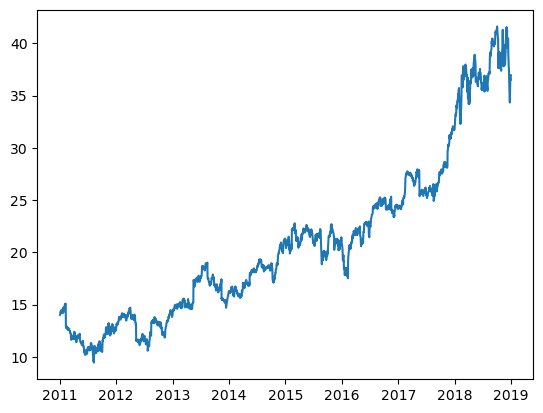

In [2]:
start_date = "2011-01-01"
end_date = "2019-01-01"

csco = yf.Ticker("CSCO").history(start = start_date, end = end_date)["Close"]
plt.plot(csco)

The percent variation in price, known as returns, can also form a time series

<Axes: xlabel='Date'>

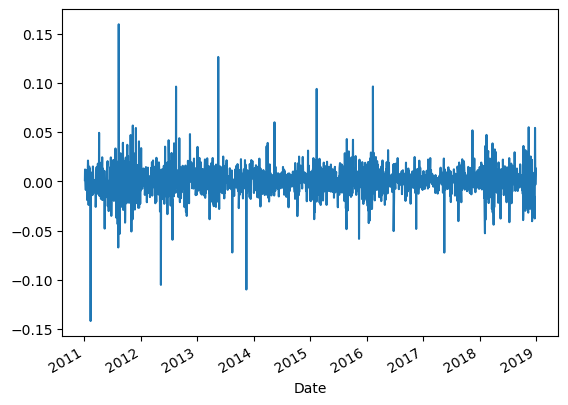

In [3]:
csco_ret = csco.pct_change().dropna()
csco_ret.plot()

The key about time series data is that the observation for a current time period may or may not depend on past observations. This property is known as autocorrelation. First, we need a theoretical introduction to what does this mean.

Multiple observations of a random variable along time are known as stochastic processes. Let's start with a simple exercise: you start at position 0, and flip a coin. If you get heads, you move +1 and if you get tails, you move -1. Mathematically, our "coin flip" can be seen as a Bernoulli random variable with $p = 0.5$. Let's imagine for our Bernoulli RV that "1" corresponds to heads and "0" corresponds to tails.

Now let's flip the coin and find out

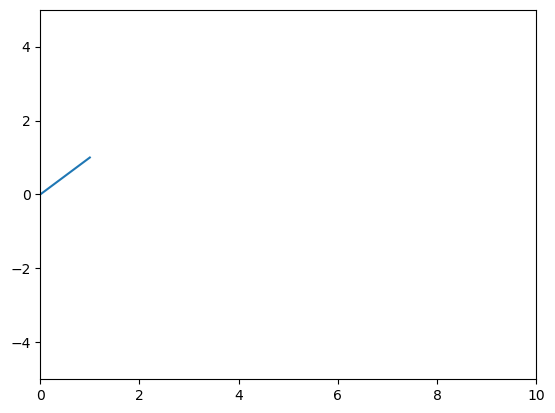

In [4]:
np.random.seed(1)

rw = np.array([0])
rw = np.append(rw, rw[0] + np.random.choice([-1,1]))
plt.ylim(-5,5)
plt.xlim(0, 10)
plt.plot(rw)

We get heads and move 1. 

Now, starting from our new position, let's flip the coin again. Since we're at 1, if we get heads we now go to 2 or, if we get tails, we go back to 0. Let's find out

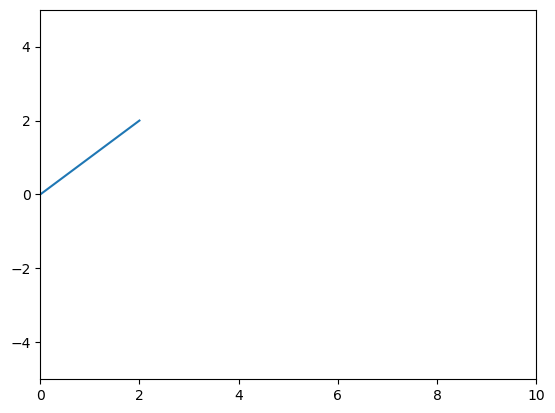

In [5]:
rw = np.append(rw, rw[1] + np.random.choice([-1,1]))
plt.ylim(-5,5)
plt.xlim(0, 10)
plt.plot(rw)

After two flips, we're at 2. Now, let's try 50 coin flips in succession and see what happens.

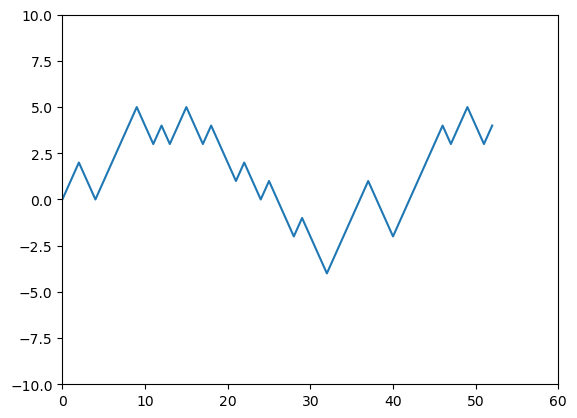

In [6]:
for i in range(2, 52):
    rw = np.append(rw, rw[i] + np.random.choice([-1,1]))
plt.ylim(-10,10)
plt.xlim(0, 60)
plt.plot(rw)

In [7]:
rw

array([ 0,  1,  2,  1,  0,  1,  2,  3,  4,  5,  4,  3,  4,  3,  4,  5,  4,
        3,  4,  3,  2,  1,  2,  1,  0,  1,  0, -1, -2, -1, -2, -3, -4, -3,
       -2, -1,  0,  1,  0, -1, -2, -1,  0,  1,  2,  3,  4,  3,  4,  5,  4,
        3,  4])

This is nothing more than an example of a random walk, one of the most important stochastic processes. Random walks can be also refered to as "Brownian motions" because of their discovery by bothanist Robert Brown in 1827, which noted that grains of pollen inside water followed a similar type of movement. In 1905, Albert Einstein provided a mathematical description of Brownian motion and used the concept to argue for the existence of atoms, claiming that the movement that we got to observe as "random" was in fact caused by the particles bumping into even smaller particles (atoms). Five years earlier, in 1900, French mathematician Louis Bachelier also provided a mathematical description of Brownian motions in the context of stock prices, giving birth to the field of mathematical finance.

A random walk is an example of a stochatic process with the presence of autocorrelation, as current observations are dependent on past ones. We can see that the price of a stock "looks like" a random walk, whereas the returns do not.

A random walk has very two important properties: it is a martingale and it follows the Markov property. 

A martingale is a process where the conditional expectation for the next value is equal to the present value, and does not depend on any values before that. For the random walk that starts at 0, if we simulate a very large number of steps we should expect the last step to be near 0.

The Markov property means that all predictions for future values of a process only depend on its current value, meaning all previous values before the current one are useless in making predictions.

The two might seem similar, but a process can be only a martingale, only Markov, both or none. The random walk with independent increments is both.

Let's simulate a very large number of steps for the random walk:

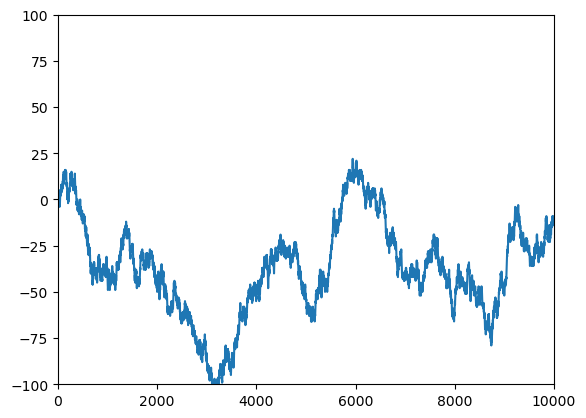

In [8]:
for i in range(52, 10000):
    rw = np.append(rw, rw[i] + np.random.choice([-1,1]))
plt.ylim(-100,100)
plt.xlim(0, 10000)
plt.plot(rw)

The random walk is centrally related to another central concept in finance, the efficient markets hypothesis (EMH). A market being efficient means that all relevant information about assets are already taken into account for the determination of its current price. If there's no way we can use the available information in order to make *deterministic* predictions, that means all innovations in price are *random*, i.e., the price follows a random walk.

Another process worth mentioning is the geometric Brownian motion (GBM). The GBM is famous for its role in the Black-Scholes model for option pricing, which assumes the price of a stock follow a GBM. This, in turn, makes it so that the returns follow a Brownian motion with drift. 

Let's try to first simulate the returns from a normal distribution, and see what the price looks like.

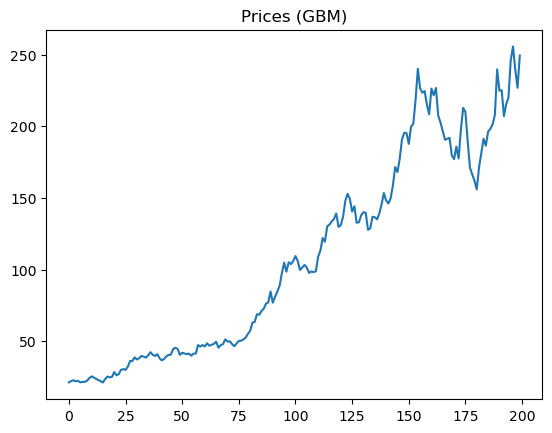

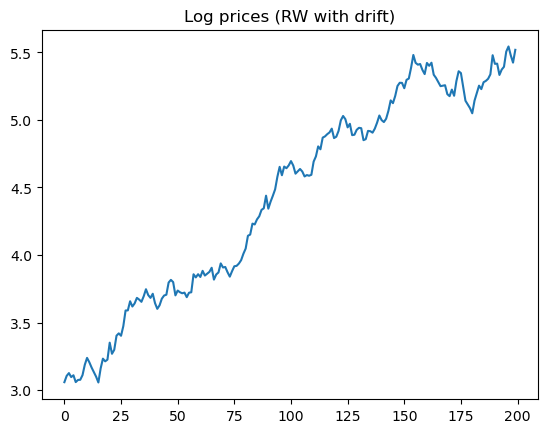

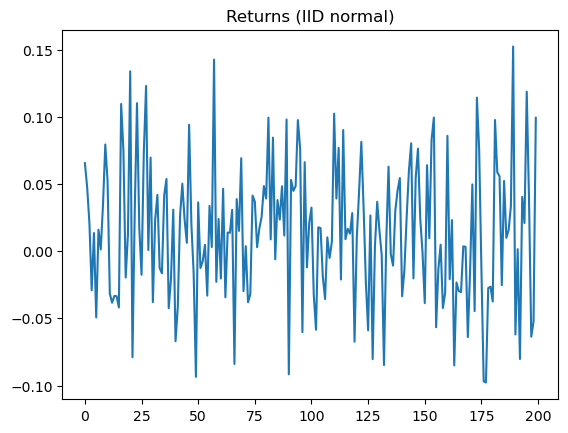

In [9]:
returns = np.empty(shape=200)
for i in range(0,len(returns)):
    returns[i] = 0.01 + 0.05 * np.random.randn()
p0 = 20
price = p0*(1+returns).cumprod()
plt.title("Prices (GBM)")
plt.plot(price)
plt.show()
plt.title("Log prices (RW with drift)")
plt.plot(np.log(price))
plt.show()
plt.title("Returns (IID normal)")
plt.plot(returns)
plt.show()

Campbell, Lo and MacKinlay (1996) cite three types of random walk tests for stock returns. The first type assumes independent and identically distributed (IID) increments, the second has independent increments and the third has uncorrelated increments. We will calculate the Cowles-Jones (CJ) ratio, a statistical test for the first type.

The CJ ratio is a ratio of *sequences* and *reversals*, where a sequence is when consecutive returns have the same sign and reversals when consecutive returns have opposite signs. If the log prices follow a random walk, and, the increments (returns) are IID with a symmetric distribution (e.g. normal), the probability of observing a sequence or a reversal is the same, and the CJ ratio tends to 1.

If the probability of a positive return is $\pi$, and a negative return has probability $(1-\pi)$, then the probability of a sequence is $\pi_s = \pi^2 + (1-\pi)^2$ and the number of sequences $N_s$ is a binomial random variable with probability $\pi_s$ and size $n$, in case we have a sample of $n+1$ returns. Then the observed CJ ratio takes the form of $\frac{N_s}{n-N_s}$.

As the CJ ratio is a function of the binomial random variable $N_s$, the delta method can be used in order to obtain the asymptotic distribution of the CJ ratio:

$\widehat{CJ} \xrightarrow{a} N\bigg(\frac{\pi_s}{1-\pi_s}, \frac{\pi_s(1-\pi_s) + 2(\pi^3+(1-\pi)^3- \pi_s^2)}{n(1-\pi_s)^4}\bigg)$,

and the null hypothesis is that our series follows a random walk, i.e., $\pi = \frac{1}{2}$.

In practice, it is the case that most of the "random walks" observed on the stock market have a drift term. The drift is responsible for introducing a deterministic trend on the process. For example, if our prices follow a GBM, the logarithm of the price shall follow a random walk with drift. For the CJ ratio, the presence of a non-null drift means that the probability of observing a sequece is larger than that of observing a reversal, and therefore the CJ ratio is greater than 1. 

The probability $\pi$ can be estimated directly from the sample, and, if the observed test statistic (the CJ ratio) falls inside or outside a certain critical region of the distribution under the null, the hypothesis of a random walk can be rejected or not. We denote the observed value $\pi$ in our sample as $\hat{\pi}$.

Denoting the estimated mean and variance of the CJ ratio, i.e., the mean and variace obtained by plugging the observed $\hat{\pi}$ for $\pi$, as $\hat{\mu}_{CJ}$ and $\hat{\sigma}^2_{CJ}$, we can obtain a test statistic $\tau_{CJ} = \sqrt{n}\bigg(\frac{\widehat{CJ} - \hat{\mu}_{CJ}}{\hat{\sigma}_{CJ}}\bigg)$ which we can compare with a standard normal distribution, not needing to assume $\pi = \frac{1}{2}$. See: https://obl20.com/wp-content/uploads/2019/04/topic1pt2-2.pdf

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_22016\706613306.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (positive_returns[i] == True) and (positive_returns[i+1] == True):
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_22016\706613306.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif (positive_returns[i] == False) and (positive_returns[i+1] == False):


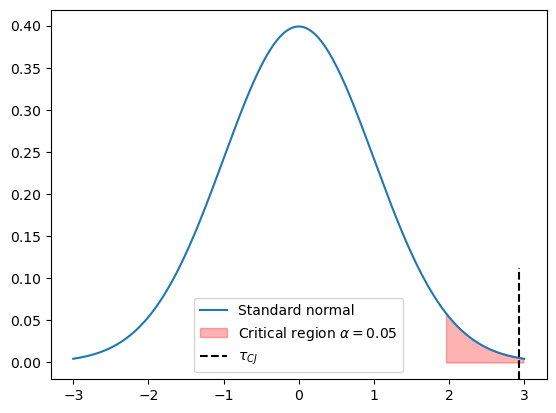

In [10]:
csco_returns = csco[400:430].pct_change().dropna()
positive_returns = csco_returns > 0
pi_est = np.sum(positive_returns)/len(csco_returns)
pi_s_est = pi_est**2 + (1-pi_est)**2

N_s = 0
for i in range(len(positive_returns)-1):
    if (positive_returns[i] == True) and (positive_returns[i+1] == True):
        N_s += 1
    elif (positive_returns[i] == False) and (positive_returns[i+1] == False):
        N_s += 1
    else:
        pass
obs_CJ_ratio = N_s/(len(positive_returns)-N_s)

CJ_mean = pi_s_est/(1-pi_s_est)
CJ_var = ((pi_s_est*(1-pi_s_est)) + 2*(pi_est**3 + (1-pi_est)**3 - pi_s_est**2))/(len(positive_returns)*(1-pi_s_est)**4)

tau_CJ = np.sqrt(len(positive_returns)) * ((obs_CJ_ratio - CJ_mean)/np.sqrt(CJ_var))

x = np.linspace(-3, 3, 1000)

plt.plot(x, st.norm.pdf(x), label = "Standard normal")
plt.fill_between(np.arange(1.96,3,1e-2),st.norm.pdf(np.arange(1.96,3,1e-2)),color='r', alpha=0.3, label=r"Critical region $\alpha=0.05$")
plt.axvline(tau_CJ, 0, 0.3, color="k", linestyle="dashed", label = r"$\tau_{CJ}$")
plt.legend()

Closely related to random walk tests, unit root tests are a way of detecting nonstationarity in time series. A random walk is one example of a unit root process. 

Common tests for unit root include the augmented Dickey-Fuller (ADF) or KPSS tests. For the ADF, the null hypothesis is the presence of a unit root, while for the KPSS the null is stationarity (and the alternative is a unit root).

Series of asset prices can be tested for unit roots. We shall apply the ADF and KPSS tests to the price of CSCO. In both tests we shall include a constant and a deterministic trend. For the ADF test we shall test

$\Delta y_{t} = \alpha + \gamma y_{t-1} + \sum_{p=1}^{d} \delta_p \Delta y_{t-p} + \varepsilon_t$,

where the null hypothesis corresponds to $\gamma = 1$. For the KPSS, we have

$y_t = \alpha + \beta t + r_t + \varepsilon_t$,

$r_t = r_{t-1} + u_t$,

where the null is that $r_t = 0$.

There is the possibility that the ADF and KPSS tests have "conflicting" results, i.e., one detects a unit root where the other doesn't, but that's because they're in fact testing different things. If the ADF detects a unit root but the KPSS doesn't, that means the series is trend stationary, whereas if the KPSS detects a unit root but the ADF doesn't, the series is difference stationary. We can make a trend stationary series into stationary by removing the trend, and make a difference stationary series into a stationary by taking the first difference.

Both tests are implemented in the statsmodels library. See: https://www.statsmodels.org/stable/examples/notebooks/generated/stationarity_detrending_adf_kpss.html

In [11]:
# ADF test with constant and drift
print("ADF test p-value: "  + str(sm.tsa.stattools.adfuller(csco, regression="c")[1]))

# KPSS test with constant and trend
print("KPSS test p-value: < "  + str(sm.tsa.stattools.kpss(csco, regression="ct")[1]))

ADF test p-value: 0.9866452720933259
KPSS test p-value: < 0.01


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_22016\2059465322.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  print("KPSS test p-value: < "  + str(sm.tsa.stattools.kpss(csco, regression="ct")[1]))


## Bid-ask spread

In practice, time series observations may not be evenly spaced throughout time. This can be the case of financial time series, where it can be the result of nonsynchronous trading. More advanced models for stock prices take this into account.

Nonsynchronous trading in financial markets can happen for many reasons, including time zones, intraday effects (e.g. opening and closing prices) or market liquidity. For this last one, the bid-ask spread is one of the key variables in understanding how it works.

The bid-ask spread is the difference between bid and ask prices for a certain asset, e.g., stock. This spread can be thought of as the price market makers charge for providing liquidity, as their ask price is higher than their bid price. The bid-ask spread represents a transaction cost, which is of great relevance as it has an impact in many models or strategies.

The microstructure can be ignored for longer investment horizons (e.g. 5 years), although the impact for shorter horizons is far from negligible. The bid-ask spread may also be responsible for an effect known as the *bid-ask bounce*, which can make an impact on a stock price's volatility and autocorrelation.

Roll (1984) proposes a model for the bid-ask bounce. Assuming a stock's fundamental price lies exactly halfway between the bid and ask prices, and, for the next period it will be traded for either the bid or the ask price, it will either stay the same or move one unit of spread up or down. It is possible to show how returns will exhibit negative autocorrelation as a consequence of this effect.

For example, if the current price is the ask, the previous price was either the ask or the bid, meaning the price either moved 0 or $s$. For the next period it will either stay at the ask, moving 0, or be traded at the bid price, moving $-s$. Conversely, if the current price is the bid, the previous price was either the ask or the bid, meaning the price moved 0 or $-s$, and for the next period it will stay at the bid, moving 0, or move $s$ to be traded at the ask. This makes it so that the returns exhibit negative autocorrelation, which will be larger as the spread becomes larger, with the same for the volatility.

We can assume a random walk process for the fundamental price, and see the effect the bid-ask bounce has on the observed price.

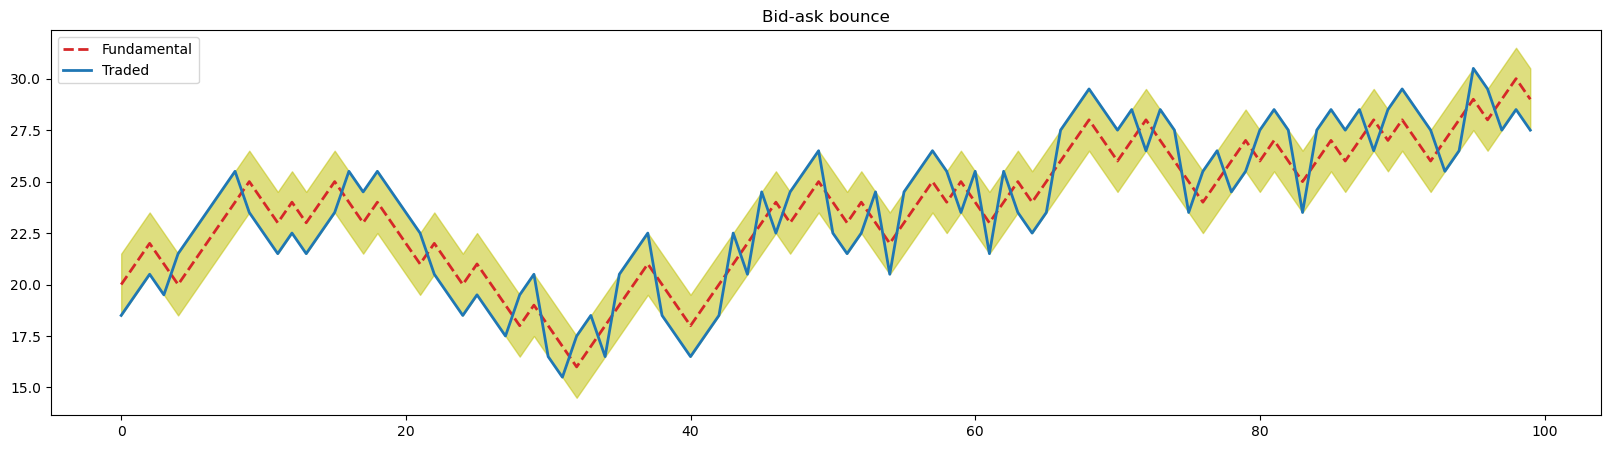

In [12]:
np.random.seed(1)
fundamental = np.array([20])
for i in range(1,100):
    fundamental = np.append(fundamental, fundamental[i-1] + np.random.choice([-1,1]))

spread = 3

traded = np.zeros(100)
for i in range(0,100):
    traded[i] = fundamental[i] - np.random.choice([-spread/2,spread/2])

plt.figure(figsize=(20,5))
plt.title("Bid-ask bounce")
plt.plot(fundamental, 'tab:red', lw=2, label="Fundamental", linestyle='dashed')
plt.plot(traded, 'tab:blue', lw=2, label="Traded", linestyle='solid')
plt.fill_between(range(len(fundamental)),fundamental - spread/2, fundamental + spread/2, color="y", alpha=0.5)
plt.legend()

## Nonlinearity in financial returns

So far, the models mentioned here are all linear, which means that changes in the inputs (e.g. the parameters) will cause proportional changes in the outputs (the returns). 

One of the main empirical properties of time series of stock returns is *volatility clustering*, which means that, usually, periods of small changes in returns are followed by more periods of small changes in returns and periods of large changes in returns are followed by periods of large changes in returns. 

Conditional heteroskedasticity models are statistical models that allow for volatility clustering, meaning that the variance of the returns is not constant, but a function of the squares of past error values. This is one example of nonlinearity, meaning a departure of linear assumptions present in the random walk, autoregressive or GBM models.

The main models using this type of approach are ARCH and GARCH models. ARCH/GARCH may assume a constant mean or an autoregressive process for the deterministic part of the returns, but instead of assuming constant volatility (standard deviation) for the errors, it models the volatility as a function of the squares of past error values, which will cause nonlinearity in the returns. The GARCH model also includes lagged volatility terms, meant to capture dependency on past realized values.

A GARCH model (usually denoted as GARCH(p,q)) with constant mean $\mu$ for returns $y_t$ has the form

$y_t = \mu + \sigma_t z_t$,

$\sigma^2_t = \omega + \sum_{i=1}^p \alpha_i \varepsilon^2_{t-i} + \sum_{i=1}^q \beta_i \sigma^2_{t-i}$,

where the noise in returns $\varepsilon_t$ is broken as $\varepsilon_t = \sigma_t z_t$ with $z_t$ being a standard normal, $p$ is the number of ARCH terms and $q$ the number of lagged volatility terms.

Another type of volatility model is stochastic volatility. Instead of assuming the volatility is a deterministic function of past error values, as in ARCH/GARCH models, SV models assume the volatility follows a stochastic process, e.g., a random walk.

SV models usually assume the logarithm of the volatility is a latent process. We will introduce latent variable modelling in the next chapter, with state space models.

We'll try to estimate a GARCH(1,1) model with the arch library

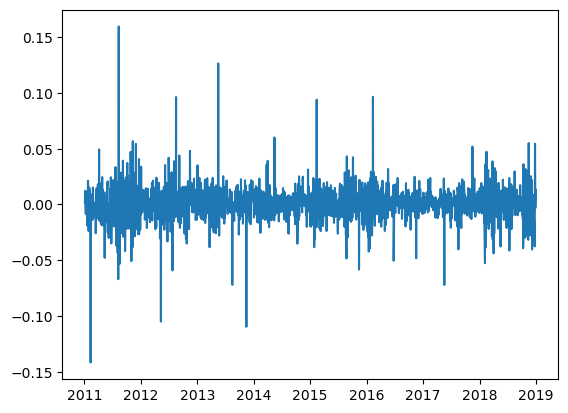

In [13]:
csco_returns = csco.pct_change().dropna()
plt.plot(csco_returns)

In [14]:
from arch import arch_model

garch = arch_model(csco_returns * 100)
garch.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 11683.781194739926
Iteration:      2,   Func. Count:     15,   Neg. LLF: 5318.5146182474155
Iteration:      3,   Func. Count:     22,   Neg. LLF: 210101.91893050127
Iteration:      4,   Func. Count:     28,   Neg. LLF: 3675.1549772020894
Iteration:      5,   Func. Count:     34,   Neg. LLF: 117892.7231960174
Iteration:      6,   Func. Count:     40,   Neg. LLF: 3707.223942874095
Iteration:      7,   Func. Count:     46,   Neg. LLF: 3659.6377166402835
Iteration:      8,   Func. Count:     52,   Neg. LLF: 3657.4940406152755
Iteration:      9,   Func. Count:     57,   Neg. LLF: 3657.47982703892
Iteration:     10,   Func. Count:     62,   Neg. LLF: 3657.4794667772558
Iteration:     11,   Func. Count:     67,   Neg. LLF: 3657.479278125459
Iteration:     12,   Func. Count:     72,   Neg. LLF: 3657.4792769117103
Iteration:     13,   Func. Count:     76,   Neg. LLF: 3657.4792769117007
Optimization terminated successfully    (Exit mode 0)
  

C:\Users\USUARIO\anaconda3\envs\pymc_env\lib\site-packages\arch\univariate\base.py:1881: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(val[pos], np.float64):
C:\Users\USUARIO\anaconda3\envs\pymc_env\lib\site-packages\arch\univariate\base.py:1882: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  converted = format_float_fixed(val[pos], *formats[i])


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3657.48
Distribution:                  Normal   AIC:                           7322.96
Method:            Maximum Likelihood   BIC:                           7345.38
                                        No. Observations:                 2011
Date:                Thu, Jan 11 2024   Df Residuals:                     2010
Time:                        13:49:13   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0631  3.636e-02      1.735  8.270e-02 [-8.17

The results show a strong significance for the constant mean $\mu$ and lagged volatility coefficient $\beta$

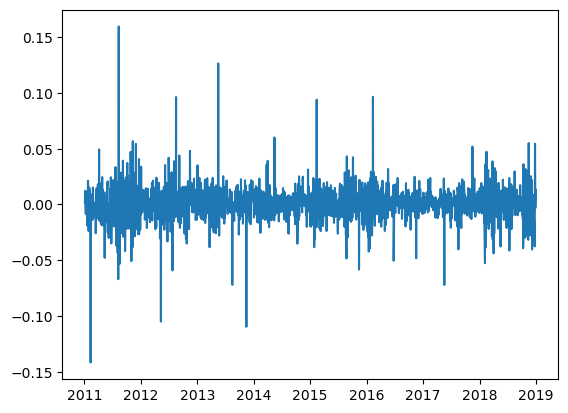

In [15]:
csco_returns = csco.pct_change().dropna()
plt.plot(csco_returns)

In [16]:
from arch import arch_model

garch = arch_model(csco_returns * 100)

garch.fit()


Iteration:      1,   Func. Count:      6,   Neg. LLF: 11683.781194739926
Iteration:      2,   Func. Count:     15,   Neg. LLF: 5318.5146182474155
Iteration:      3,   Func. Count:     22,   Neg. LLF: 210101.91893050127
Iteration:      4,   Func. Count:     28,   Neg. LLF: 3675.1549772020894
Iteration:      5,   Func. Count:     34,   Neg. LLF: 117892.7231960174
Iteration:      6,   Func. Count:     40,   Neg. LLF: 3707.223942874095
Iteration:      7,   Func. Count:     46,   Neg. LLF: 3659.6377166402835
Iteration:      8,   Func. Count:     52,   Neg. LLF: 3657.4940406152755
Iteration:      9,   Func. Count:     57,   Neg. LLF: 3657.47982703892
Iteration:     10,   Func. Count:     62,   Neg. LLF: 3657.4794667772558
Iteration:     11,   Func. Count:     67,   Neg. LLF: 3657.479278125459
Iteration:     12,   Func. Count:     72,   Neg. LLF: 3657.4792769117103
Iteration:     13,   Func. Count:     76,   Neg. LLF: 3657.4792769117007
Optimization terminated successfully    (Exit mode 0)
  

C:\Users\USUARIO\anaconda3\envs\pymc_env\lib\site-packages\arch\univariate\base.py:1881: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(val[pos], np.float64):
C:\Users\USUARIO\anaconda3\envs\pymc_env\lib\site-packages\arch\univariate\base.py:1882: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  converted = format_float_fixed(val[pos], *formats[i])


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3657.48
Distribution:                  Normal   AIC:                           7322.96
Method:            Maximum Likelihood   BIC:                           7345.38
                                        No. Observations:                 2011
Date:                Thu, Jan 11 2024   Df Residuals:                     2010
Time:                        13:49:13   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0631  3.636e-02      1.735  8.270e-02 [-8.17

The results show a strong significance for the constant mean $\mu$ and lagged volatility coefficient $\beta$

## Value at risk

With many tools at our hands to model stock returns over time, how could we use this information to protect ourselves against extreme market swings? Or calculate the probability of worst case scenarios for returns?

The most famous way of doing this is by calculating value at risk (VaR). VaR gives us the maximum expected loss for a given confidence level. For example, a VaR of 100000 USD with 95% confidence means that the maximum loss will not exceed 100000 USD, except for the 5% worst case scenarios. The VaR is calculated over a holding period, e.g., 1 year, 1 month...

The VaR can be calculated for a certain stock, asset or even a diversified portfolio.

There are three ways to calculate VaR: parametric, historical and Monte Carlo. 

The parametric method involves assuming a probability distribution for the returns (usually the normal distribution), estimating the parameters, e.g. mean and standard deviation, and then obtain the VaR as a percentile of the assumed distribution with the estimated parameters. For example: the 95% confidence level parametric VaR for the normal distribution is the 5th percentile of the normal distribution, i.e., the point of the curve for which we have a 5% probability of observing a smaller value. Due to the fact that, for a portfolio, estimating the standard deviation of the portfolio requires obtaining the variance-covariance matrix of the assets, this is also known as the variance-covariance method. This method may not work properly if the returns do not follow the assumed distribution.

The historical method relies on the empirical distribution of historical returns, sorting them from worst to best and then looking at quantiles: the 95% confidence level historical VaR corresponds to the 5th percentile (in this case the value that is greater than 5% of the historical returns) of the empirical distribution. The main assumption is that the same distribution pattern observed in the past will repeat in the future, so this method tends to be less reliable with smaller samples.

And finally, the Monte Carlo method also requires assuming a statistical model for the returns, and then simulating a large number of returns, from which we will obtain the VaR as a percentile. The statistical model can be a normal distribution, although in this case the VaR is more easily obtaining from the parametric method. The Monte Carlo method really shines when we assume more complex models for the returns, e.g., GARCH or stochastic volatility models, for which the parametric VaR is much more difficult to obtain.

We shall give an example of VaR calculations (95% confidence and investment of $100000) with all three methods:

In [17]:
csco_returns = csco[1800:2100].pct_change().dropna()
csco_returns.head()

Date
2018-03-01 00:00:00-05:00   -0.021884
2018-03-02 00:00:00-05:00    0.005936
2018-03-05 00:00:00-05:00    0.010440
2018-03-06 00:00:00-05:00   -0.005166
2018-03-07 00:00:00-05:00   -0.002032
Name: Close, dtype: float64

In [18]:
investment = 100000
conf_level = 0.95

# Parametric VaR

returns_mean = csco_returns.mean()
returns_vol = csco_returns.std()

mean_inv = (1+returns_mean) * investment
std_inv = returns_vol * investment

parametric_var = investment - st.norm.ppf(1 - conf_level, mean_inv, std_inv)
print("Value at risk (P): $" + str(parametric_var.round(2)))

Value at risk (P): $2658.25


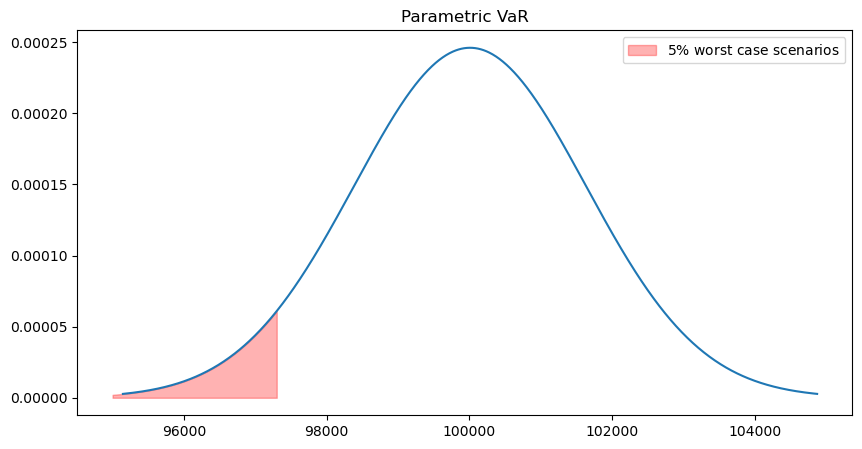

In [19]:
x = np.linspace(mean_inv - 3 * std_inv, mean_inv + 3 * std_inv, 1000)

plt.figure(figsize=(10,5))
plt.title("Parametric VaR")
plt.plot(x, st.norm.pdf(x, mean_inv, std_inv), label = "")
plt.fill_between(np.arange(95000,st.norm.ppf(1 - conf_level, mean_inv, std_inv),1e2),st.norm.pdf(np.arange(95000,st.norm.ppf(1 - conf_level, mean_inv, std_inv),1e2), mean_inv, std_inv),color='r', alpha=0.3, label=r"$5\%$ worst case scenarios")
plt.legend()

Value at risk (H): $3052.16


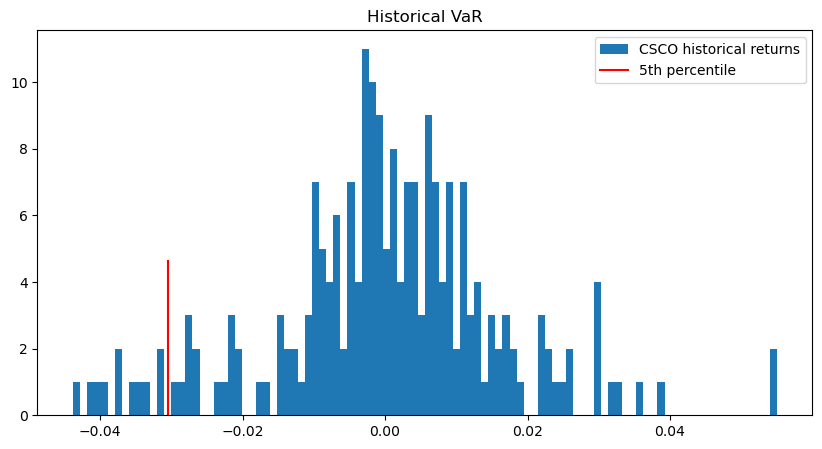

In [20]:
# Historical VaR

historical_var = abs(investment * csco_returns.sort_values().quantile(1 - conf_level))
print("Value at risk (H): $" + str(historical_var.round(2)))

csco_returns.hist(bins=100, grid=False, label="CSCO historical returns", figsize=(10,5))
plt.title("Historical VaR")
plt.axvline(csco_returns.sort_values().quantile(1 - conf_level), 0, 0.4, color="r", label="5th percentile")
plt.legend()

In [21]:
# Monte Carlo VaR: normal vs Student's t (df=10)

MC_steps = 100000
df = 10
np.random.seed(1)

returns_mean = csco_returns.mean()
returns_vol = csco_returns.std()

normal_returns = returns_mean + returns_vol * np.random.standard_normal(MC_steps)
t_returns = returns_mean + returns_vol * np.random.standard_t(df, MC_steps)

MC_var_normal = abs(investment * np.percentile(normal_returns, 1-conf_level))
MC_var_t = abs(investment * np.percentile(t_returns, 1-conf_level))

print("Value at risk (MC, normal): $" + str(MC_var_normal.round(2)))
print("Value at risk (MC, t): $" + str(MC_var_t.round(2)))

Value at risk (MC, normal): $5408.6
Value at risk (MC, t): $7546.09


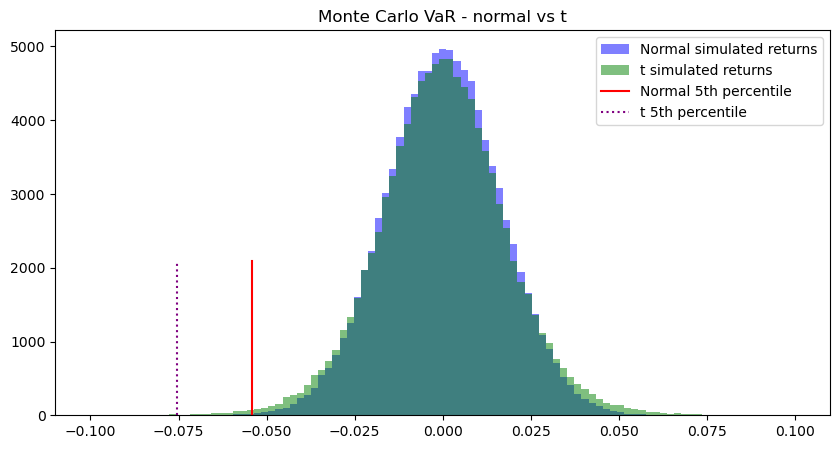

In [22]:
plt.figure(figsize=(10,5))
plt.title("Monte Carlo VaR - normal vs t")
bins = np.linspace(-0.1, 0.1, 100)
plt.hist(normal_returns, bins=bins, alpha=0.5, color="b", label="Normal simulated returns")
plt.hist(t_returns, bins=bins, alpha=0.5, color="g", label="t simulated returns")
plt.axvline(np.percentile(normal_returns, 1-conf_level), 0, 0.4, color="r", label="Normal 5th percentile")
plt.axvline(np.percentile(t_returns, 1-conf_level), 0, 0.4, color="purple", linestyle="dotted", label="t 5th percentile")
plt.legend()
plt.show()

One of the main problems with VaR is that, as it is defined as a percentile, it does not account for the shape of the tail of the distribution. Another measure of risk known as *expected shortfall* (ES) seeks to solve this problem.

As the VaR gives us the probability of observing returns lower than a given quantity, ES conditions on having observed a return lower than our quantity of interest and gives us the expected loss. This is why ES is also known as conditional VaR, or CVaR.

The ES can be calculated in the same three ways as the VaR: parametric, historical and Monte Carlo. We shall now provide examples of the three:

In [23]:
investment = 100000
conf_level = 0.95

# Parametric ES

returns_mean = csco_returns.mean()
returns_vol = csco_returns.std()

mean_inv = (1+returns_mean) * investment
std_inv = returns_vol * investment

# 5th percentile
alpha_perc = st.norm.ppf(1 - conf_level, mean_inv, std_inv)

normal_values = np.linspace(mean_inv - 3 * std_inv, mean_inv + 3 * std_inv, 10000)
tail_dist = normal_values[normal_values < alpha_perc]

parametric_es = investment - np.mean(tail_dist)
print("Expected shortfall (P): $" + str(parametric_es.round(2)))

Expected shortfall (P): $3756.81


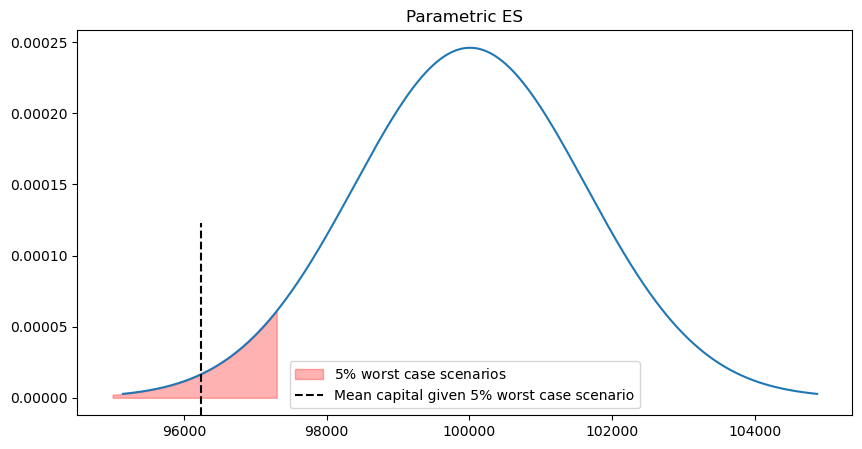

In [24]:
plt.figure(figsize=(10,5))
plt.title("Parametric ES")
plt.plot(normal_values, st.norm.pdf(normal_values, mean_inv, std_inv), label = "")
plt.fill_between(np.arange(95000,st.norm.ppf(1 - conf_level, mean_inv, std_inv),1e2),st.norm.pdf(np.arange(95000,st.norm.ppf(1 - conf_level, mean_inv, std_inv),1e2), mean_inv, std_inv),color='r', alpha=0.3, label=r"$5\%$ worst case scenarios")
plt.axvline(np.mean(tail_dist), 0, 0.5, color="k", linestyle="dashed", label="Mean capital given 5% worst case scenario")
plt.legend()

Expected shortfall (H): $3690.14


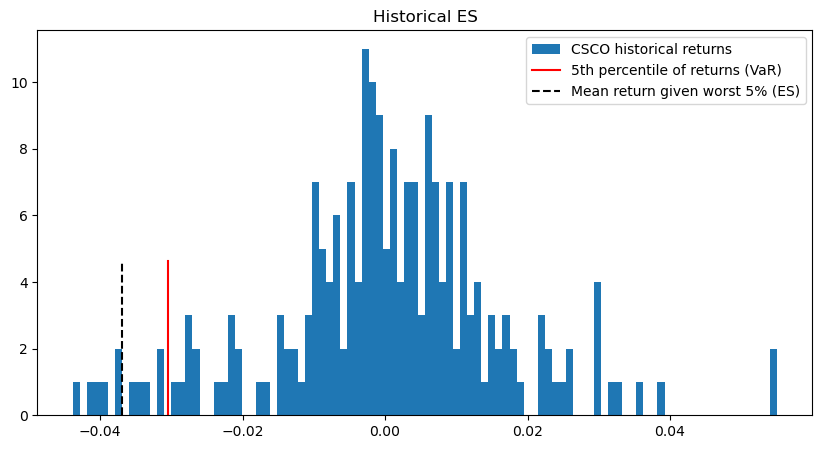

In [25]:
# Historical ES

hist_returns = csco_returns.sort_values()
historical_es = abs(investment * hist_returns[hist_returns < hist_returns.quantile(1 - conf_level)].mean())
print("Expected shortfall (H): $" + str(round(historical_es,2)))

csco_returns.hist(bins=100, grid=False, label="CSCO historical returns", figsize=(10,5))
plt.title("Historical ES")
plt.axvline(hist_returns.quantile(1 - conf_level), 0, 0.4, color="r", label="5th percentile of returns (VaR)")
plt.axvline(hist_returns[hist_returns < hist_returns.quantile(1 - conf_level)].mean(), 0, 0.4, color="k", linestyle="dashed", label="Mean return given worst 5% (ES)")
plt.legend()

In [26]:
# Monte Carlo ES

MC_steps = 100000
df = 10
np.random.seed(1)

returns_mean = csco_returns.mean()
returns_vol = csco_returns.std()

normal_returns = returns_mean + returns_vol * np.random.standard_normal(MC_steps)
t_returns = returns_mean + returns_vol * np.random.standard_t(df, MC_steps)

MC_ES_normal = abs(investment * np.mean(normal_returns[normal_returns < np.percentile(normal_returns, 1-conf_level)]))
MC_ES_t = abs(investment * np.mean(t_returns[t_returns < np.percentile(t_returns, 1-conf_level)]))

print("Expected shortfall (MC, normal): $" + str(MC_ES_normal.round(2)))
print("Expected shortfall (MC, t): $" + str(MC_ES_t.round(2)))

Expected shortfall (MC, normal): $5824.1
Expected shortfall (MC, t): $8750.19


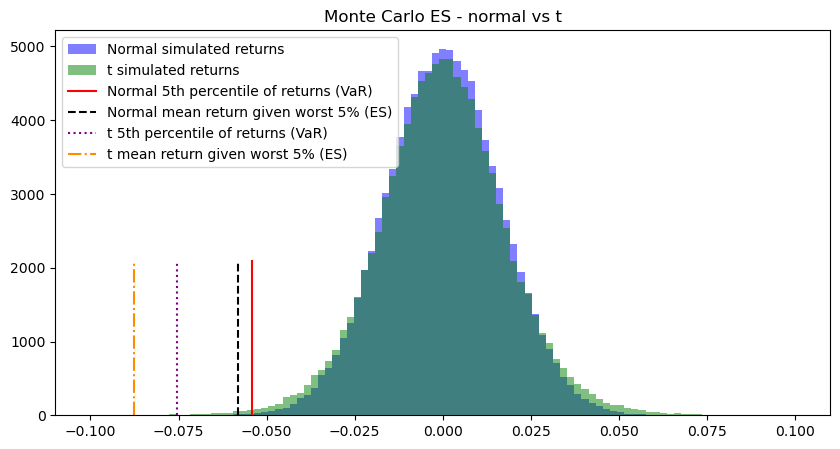

In [27]:
plt.figure(figsize=(10,5))
plt.title("Monte Carlo ES - normal vs t")
bins = np.linspace(-0.1, 0.1, 100)
plt.hist(normal_returns, bins=bins, alpha=0.5, color="b", label="Normal simulated returns")
plt.hist(t_returns, bins=bins, alpha=0.5, color="g", label="t simulated returns")
plt.axvline(np.percentile(normal_returns, 1-conf_level), 0, 0.4, color="r", label="Normal 5th percentile of returns (VaR)")
plt.axvline(np.mean(normal_returns[normal_returns < np.percentile(normal_returns, 1-conf_level)]), 0, 0.4, color="k", linestyle="dashed", label="Normal mean return given worst 5% (ES)")
plt.axvline(np.percentile(t_returns, 1-conf_level), 0, 0.4, color="purple", linestyle="dotted", label="t 5th percentile of returns (VaR)")
plt.axvline(np.mean(t_returns[t_returns < np.percentile(t_returns, 1-conf_level)]), 0, 0.4, color="darkorange", linestyle="dashdot", label="t mean return given worst 5% (ES)")
plt.legend()
plt.show()

It is possible to use Monte Carlo to simulate returns according to a GARCH model, and then calculate VaR and ES. First, we fit a GARCH model to our series of returns

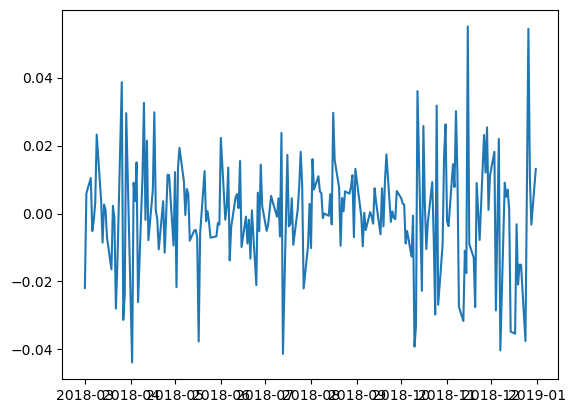

In [28]:
plt.plot(csco_returns)

In [29]:
garch = arch_model(csco_returns * 100)
res = garch.fit()
res

Iteration:      1,   Func. Count:      6,   Neg. LLF: 955.9237245434853
Iteration:      2,   Func. Count:     14,   Neg. LLF: 1576454029.9390757
Iteration:      3,   Func. Count:     21,   Neg. LLF: 405.5684929224754
Iteration:      4,   Func. Count:     28,   Neg. LLF: 389.3100073356293
Iteration:      5,   Func. Count:     34,   Neg. LLF: 386.3111187820463
Iteration:      6,   Func. Count:     39,   Neg. LLF: 386.27974063403224
Iteration:      7,   Func. Count:     44,   Neg. LLF: 386.2766108030851
Iteration:      8,   Func. Count:     49,   Neg. LLF: 386.2764268058654
Iteration:      9,   Func. Count:     54,   Neg. LLF: 386.2764203397132
Iteration:     10,   Func. Count:     58,   Neg. LLF: 386.2764203398248
Optimization terminated successfully    (Exit mode 0)
            Current function value: 386.2764203397132
            Iterations: 10
            Function evaluations: 58
            Gradient evaluations: 10


C:\Users\USUARIO\anaconda3\envs\pymc_env\lib\site-packages\arch\univariate\base.py:1881: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(val[pos], np.float64):
C:\Users\USUARIO\anaconda3\envs\pymc_env\lib\site-packages\arch\univariate\base.py:1882: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  converted = format_float_fixed(val[pos], *formats[i])


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -386.276
Distribution:                  Normal   AIC:                           780.553
Method:            Maximum Likelihood   BIC:                           793.960
                                        No. Observations:                  211
Date:                Thu, Jan 11 2024   Df Residuals:                      210
Time:                        13:49:20   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.1088  9.563e-02      1.138      0.255 [-7.86

None of our estimated parameters are significant at the 5% level, but we'll ignore that and use the estimated parameter values for our example.

Recall the GARCH model formula is

$y_t = \mu + \sigma_t z_t$,

$\sigma^2_t = \omega + \sum_{i=1}^p \alpha_i \varepsilon^2_{t-i} + \sum_{i=1}^q \beta_i \sigma^2_{t-i}$,

so we'll run the Monte Carlo according to that. Since our number of MC steps was 100000, we'll simulate 500 GARCH processes with length 200 each:

In [30]:
# Use sample variance as sigma_0
sigma_0 = (csco_returns * 100).std()
eps_0 = np.random.randn() * sigma_0

# Simulate 500 GARCH processes with length 200 each

processes = 500
process_len = 200
garch_sim = np.empty((processes,process_len))
returns_sim = np.empty((processes,process_len))

for i in range(processes):
    garch_sim[i][0] = res.params["omega"] + res.params["alpha[1]"] * (eps_0**2) + res.params["beta[1]"] * (sigma_0**2)
    eps = np.sqrt(garch_sim[i][0]) * np.random.randn()
    returns_sim[i][0] = res.params["mu"] + eps

for i in range(processes):
    for j in range(process_len-1):
        garch_sim[i][j+1] = res.params["omega"] + res.params["alpha[1]"] * (eps**2) + res.params["beta[1]"] * garch_sim[i][j]
        eps = np.sqrt(garch_sim[i][j+1]) * np.random.randn()
        returns_sim[i][j+1] = res.params["mu"] + eps

# Scaling
returns_sim = returns_sim/100

We then lump all of the simulated returns for each process in one distribution

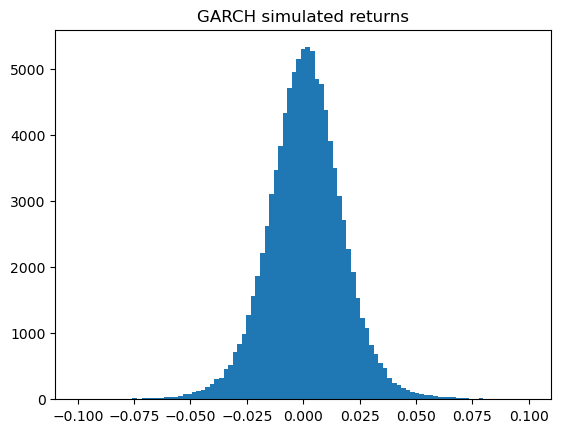

In [31]:
plt.title("GARCH simulated returns")
bins = np.linspace(-0.1, 0.1, 100)
plt.hist(returns_sim.flatten(), bins=bins)
plt.show()

In [32]:
investment = 100000
conf_level = 0.95
MC_steps = 100000
np.random.seed(1)

returns_mean = csco_returns.mean()
returns_vol = csco_returns.std()

normal_returns = returns_mean + returns_vol * np.random.standard_normal(MC_steps)

MC_var_normal = abs(investment * np.percentile(normal_returns, 1-conf_level))
MC_var_GARCH = abs(investment * np.percentile(returns_sim, 1-conf_level))

MC_ES_normal = abs(investment * np.mean(normal_returns[normal_returns < np.percentile(normal_returns, 1-conf_level)]))
MC_ES_GARCH = abs(investment * np.mean(returns_sim[returns_sim < np.percentile(returns_sim, 1-conf_level)]))

print("Value at risk (MC, normal): $" + str(MC_var_normal.round(2)))
print("Value at risk (MC, GARCH): $" + str(MC_var_GARCH.round(2)))
print("Expected shortfall (MC, normal): $" + str(MC_ES_normal.round(2)))
print("Expected shortfall (MC, GARCH): $" + str(MC_ES_GARCH.round(2)))

Value at risk (MC, normal): $5408.6
Value at risk (MC, GARCH): $7724.47
Expected shortfall (MC, normal): $5824.1
Expected shortfall (MC, GARCH): $9058.31


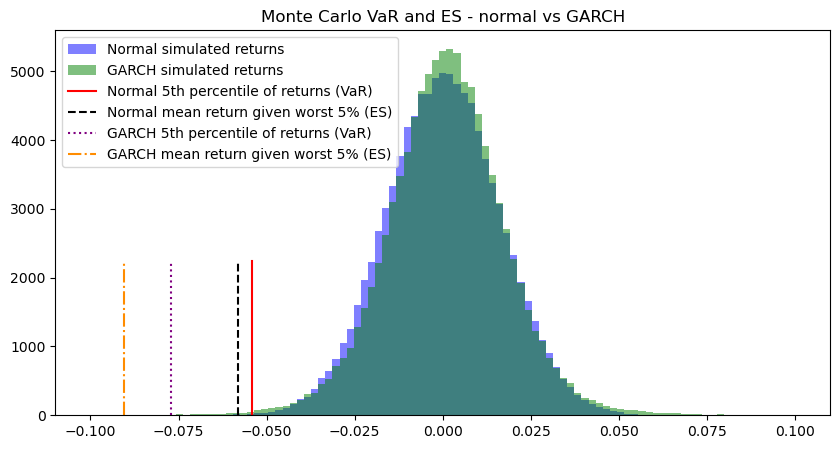

In [33]:
plt.figure(figsize=(10,5))
plt.title("Monte Carlo VaR and ES - normal vs GARCH")
bins = np.linspace(-0.1, 0.1, 100)
plt.hist(normal_returns, bins=bins, alpha=0.5, color="b", label="Normal simulated returns")
plt.hist(returns_sim.flatten(), bins=bins, alpha=0.5, color="g", label="GARCH simulated returns")
plt.axvline(np.percentile(normal_returns, 1-conf_level), 0, 0.4, color="r", label="Normal 5th percentile of returns (VaR)")
plt.axvline(np.mean(normal_returns[normal_returns < np.percentile(normal_returns, 1-conf_level)]), 0, 0.4, color="k", linestyle="dashed", label="Normal mean return given worst 5% (ES)")
plt.axvline(np.percentile(returns_sim.flatten(), 1-conf_level), 0, 0.4, color="purple", linestyle="dotted", label="GARCH 5th percentile of returns (VaR)")
plt.axvline(np.mean(returns_sim.flatten()[returns_sim.flatten() < np.percentile(returns_sim.flatten(), 1-conf_level)]), 0, 0.4, color="darkorange", linestyle="dashdot", label="GARCH mean return given worst 5% (ES)")
plt.legend()
plt.show()

### Additional references for this section

Bodie, Z., Kane, A., Marcus, A. J. (2018). Investments. Chapter 5 details risk measures such as VaR and ES, and Chapter 11 explains random walks in the context of financial asset prices, and the EMH.

MacKinlay, A. C., Lo, A. W., Campbell, J. Y. (2012). The Econometrics of Financial Markets. Chapter 2 describes random walks and tests for the random walk hypothesis, and Chapter 3 is about market microstructure. Chapter 12 describes estimation for stochastic volatility models.